### Import Dependencies

In [2]:
import csv           #for read write csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load CSV Data

In [3]:
df = pd.read_csv(r'water_data.csv')
array = np.array(df)

#delete redundent column and check data
#each column represents the following water data: 
#index, date, time, water temperature, pH, dissolve oxygen (DO), and electrical conductivity (EC)
data = array[:,0:7]
data.shape

(4273, 7)

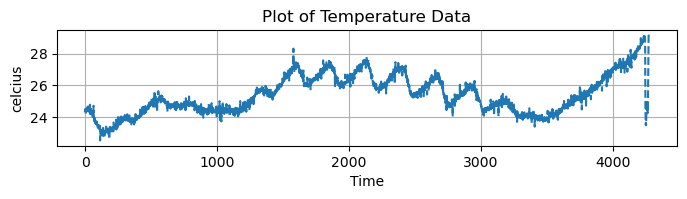

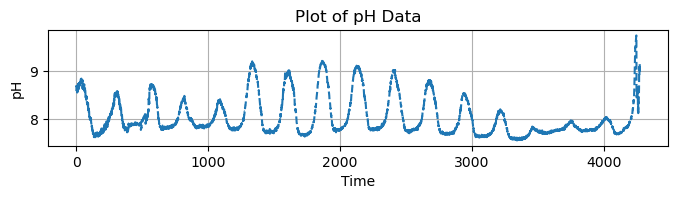

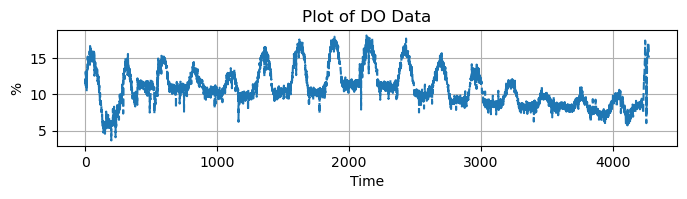

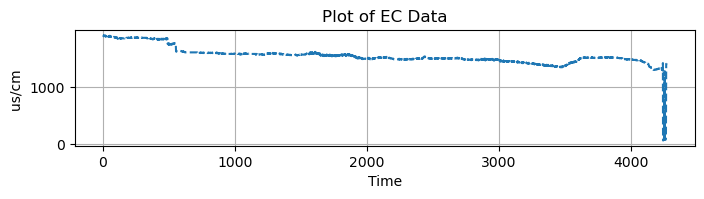

In [4]:
#Plot the datas and have a look
data_names = ["Temperature", "pH", "DO", "EC"]
units = ["celcius", "pH", "%", "us/cm "]
for i in range(len(data_names)):
    plt.figure(figsize=(8, 1.5))
    plt.title('Raw Data')
    plt.plot(np.transpose(data[:,0]), np.transpose(data[:,i+3]), linestyle='--')
    plt.xlabel("Time")
    plt.ylabel(units[i])
    plt.title("Plot of " + data_names[i] + " Data")
    plt.grid()
    # name = str(i)
    # plt.savefig(name+'.png', bbox_inches='tight')     # for saving the plots
    plt.show()
    

### Z-Normalize Data

In [5]:
#first, we are only interested in water parameter datas, which are column 3 to 6
water_data = data[0:4000,3:7]

#define empty array for putting normalized water data
water_data_norm = np.zeros(water_data.shape)

#define empty array for mean and variance
water_data_var = np.zeros(water_data.shape[1])
water_data_mean = np.zeros(water_data.shape[1])


data_names = ["Temperature", "pH", "DO", "EC"]
z_normalizing_constant = {name : {} for name in data_names}

#carryout normalization by each column
for i in range(water_data.shape[1]):
    # calculate mean and variance for each data column
    water_data_var[i] = np.var(water_data[:,i])
    water_data_mean[i] = np.mean(water_data[:,i])

    # record mean and variance of water data
    name = data_names[i]
    z_normalizing_constant[name]['var'] = water_data_var[i]
    z_normalizing_constant[name]['mean'] = water_data_mean[i]

    #conduct z-normalization by subtracting sample mean and divided by standard deviation
    water_data_norm[:,i] = (water_data[:,i] - water_data_mean[i]) / np.sqrt(water_data_var[i])

np.save('normalizing_constants', z_normalizing_constant)

#now we can test our normalized data by looking at its mean...
print(np.mean(water_data_norm))   # very close to zero

1.2278178473934531e-14


In [6]:
# the mean and variance used in normalizing the data are important!
# we will have to do the same transformation for future normalization 
z_normalizing_constant

{'Temperature': {'var': 1.1551278036937513, 'mean': 25.254617500000002},
 'pH': {'var': 0.16354016094374732, 'mean': 8.04423249999998},
 'DO': {'var': 6.379821424797464, 'mean': 10.969207249999997},
 'EC': {'var': 16632.41791493756, 'mean': 1556.87025}}

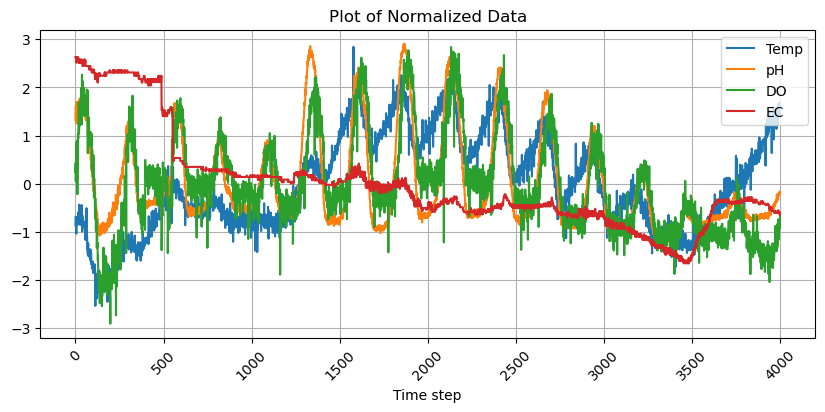

In [7]:
#Plot normalized data and have a look
plt.figure(figsize = (10,4))
plt.title('Plot of Normalized Data')
plt.xlabel('Time step')
plt.ylabel('') 

plt.plot(np.transpose(water_data_norm[:,0]), linestyle='-',label='Temp')
plt.plot(np.transpose(water_data_norm[:,1]), linestyle='-',label='pH')
plt.plot(np.transpose(water_data_norm[:,2]), linestyle='-',label='DO')
plt.plot(np.transpose(water_data_norm[:,3]), linestyle='-',label='EC')
plt.xticks(rotation=45)

plt.legend(loc='upper right')
plt.grid()
name = "normalized"
plt.savefig(name+'.png', bbox_inches='tight')     # for saving the plots/
plt.show()

### Fitting the model

In [8]:
# Now, we are ready to fit the multivariant gaussian (4 dimenisons in this case), to our data as the kernel of our model
# note that we shall define a function to normalize our input to the distribution first.
# water_dataa_normalize() shall be updated when training data is changed
def water_data_normalize(input):
    output = np.divide((input - water_data_mean),np.sqrt(water_data_var))
    return output

# We then obtain the covariance matrix, which will be a constant term in the model
water_data_cov = np.cov(np.transpose(water_data_norm))

# then, we fit the maximum likelyhood multivariant gaussian PDF to given data
# In our case, dimension of data = 4 (temp, pH, DO, EC)
# As we have already normalized the training data, this function is maxed at [0 0 0 0]
def water_mul_var_gauss(water_data_input):
    dim = water_data_input.shape[0]
    constant_term = 1/((2*np.pi)**(dim/2))
    one_over_det_sqrt = 1/np.linalg.det(water_data_cov)**(1/2)
    exponent_term = (-1/2)*np.transpose(water_data_input)@np.linalg.inv(water_data_cov)@water_data_input
    # NOTE: 0.06 is the "height" of the distribution, obtained by inputting [0,0,0,0]
    # dividing by 0.06 allows output of this function to be between 1 and 0
    
    return (constant_term*one_over_det_sqrt*np.exp(exponent_term)) / 0.06004116676124076

In [9]:
# Quick test on the distribution
# Given two status of water:
good_water = np.array([25.25, 8, 10, 1500])
bad_water = np.array([20, 9, 4, 600])
# first normalize the data
good_water_norm = water_data_normalize(good_water)
bad_water_norm = water_data_normalize(bad_water)

# Evaluate if it is anomaly data point:
score1 = water_mul_var_gauss(good_water_norm)
score2 = water_mul_var_gauss(bad_water_norm)

print("good water score: ", score1)   # relatively high score
print("bad water score: ", score2)    # something close to zero


good water score:  0.759259590394292
bad water score:  2.653081006236136e-63


### Demonstration of suggestion mechanism

In [28]:
# Here I demonstrate the core mechanic for the suggestion algorithm:
# given a bad water condition:
bad_water = np.array([29, 7.8, 10, 1500])

# normalized and evaulate its score:
bad_water_norm = water_data_normalize(bad_water)
score = water_mul_var_gauss(bad_water_norm)
print("score of water condition: ", score)
print("very poor water condition!")

score of water condition:  1.8870621601720394e-05
very poor water condition!


/tmp/ipykernel_34261/2991536691.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_34261/2991536691.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


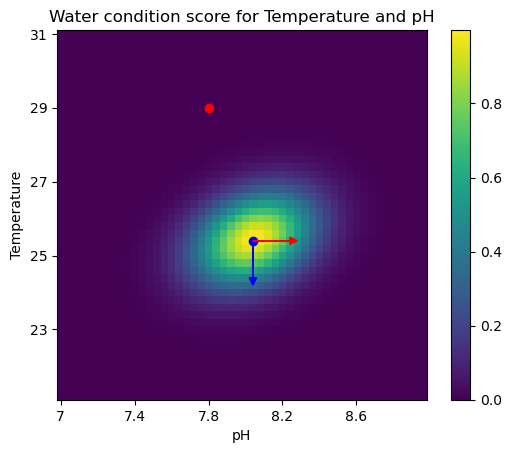

In [53]:
# Lets consider only two dimension (temp and pH) for sake of demonstration, plotting the score function for these two dimension
mean_DO = 10.969207249999997
mean_EC = 1556.87025
# Create a 2D numpy array (example data)
data = np.zeros((50, 50))

25.25
8.044

# Propogate the heatmap
for i in range(50):
    for j in range(50):
        temp = 21+0.2*i
        pH = 7+0.04*j
        water  = np.array([temp, pH, mean_DO, mean_EC])
        water_norm = water_data_normalize(water)
        temp_score = water_mul_var_gauss(water_norm)

        data[49-i,j] = temp_score

# Plot the heatmap
fig, ax = plt.subplots()
fig.canvas.draw()
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]
ph_ticks = ["7", "7.4", "7.8", "8.2", "8.6"]
temp_ticks = ["31", "29", "27", "25", "23"]

for idx in range(1,6):
    ylabels[idx] = temp_ticks[idx-1]
    xlabels[idx] = ph_ticks[idx-1]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.title("Water condition score for Temperature and pH")
plt.colorbar()  # Add color bar indicating the scale
plt.ylabel("Temperature")
plt.xlabel("pH")

# Uncomment for water condition plot
plt.scatter(20, 10, color='red', marker='o')  # plot of [25 7.8 11 1550]
plt.scatter(26, 28, color='blue', marker='o')  # plot of [28 8.2 11 1550]

# Uncomment for suggestion vectors
plt.arrow(26, 28, 0, 5, head_width=1, head_length=1, fc='blue', ec='blue')
plt.arrow(26, 28, 5, 0, head_width=1, head_length=1, fc='red', ec='red')

# Save the plot
# name = "heatmap"
# plt.savefig(name+'.png', bbox_inches='tight')     # for saving the plots/
# plt.show()

In [54]:
# To give suggestions, we first find the gradient of the data point in the distribution function
# Derative of multivariant gaussian with mean = 0 is:
# -Sigma * x * f(x)
# in fact, we only need -Sigma * x, as we only need the direction of gradient when choosign suggestion
def gradient(x):
    score = water_mul_var_gauss(x)
    M = np.linalg.inv(water_data_cov)
    output = -M @ x
    return output


In [55]:
# find the gradient of the water in the function
grad = gradient(bad_water_norm)
grad /= np.linalg.norm(grad)       #normalized as we only care about direction

In [56]:
# Finally, we use the gradient vector to calculate most suitable suggestion
suggestion = {}
suggestion['sug1'] = {}
suggestion['sug2'] = {}
suggestion['sug3'] = {}


suggestion['sug1']['vec'] = np.array([-1, 0, 0, 0])    # make sure this vector has norm 1
suggestion['sug1']['str'] = "Cool down water by covering the pond"
suggestion['sug2']['vec'] = np.array([0, 0, 1, 0])
suggestion['sug2']['str'] = "Turn on oxygen pump!"
suggestion['sug3']['vec'] = np.array([0, 1, 0, 0])    # make sure this vector has norm 1
suggestion['sug3']['str'] = "Reduce pH by adding enzymes"

In [57]:
# project gradient to each suggestion vector
values_dict = {}
values = []

for key in suggestion:
    s_vec = suggestion[key]['vec']
    value = np.inner(grad, s_vec)
    values.append(value)
    values_dict[value] = [key]


In [58]:
# we then sort the magnitude of each projection, and print the corrsponding suggestion
values.sort(reverse = True)
best_value = values[0]
best_suggestion = values_dict[best_value][0]
suggestion[best_suggestion]['str']

'Cool down water by covering the pond'